In [ ]:
!pip3 install git+https://github.com/AdamCobb/hamiltorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AdamCobb/hamiltorch to /tmp/pip-req-build-47r7wwms
  Running command git clone -q https://github.com/AdamCobb/hamiltorch /tmp/pip-req-build-47r7wwms
  Created wheel for hamiltorch: filename=hamiltorch-0.4.0.dev1-py3-none-any.whl size=20130 sha256=536da041e8a2ad426eaff9552bc4ac490e646858b7baf4dffdfd8636a1bb0923
  Stored in directory: /tmp/pip-ephem-wheel-cache-4grmtdfb/wheels/94/33/56/4cf57b40759f68de688e5e01bee26d036f98048a16a9733e9b
Successfully built hamiltorch


# **Packages**

In [ ]:
import torch
import hamiltorch
import torchvision
import time
import math
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal


%matplotlib inline

# **Device**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **MNIST Dataset**

In [ ]:
trainset = torchvision.datasets.MNIST('./data/', train=True, download=True, 
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize((0.1307,), (0.3081,)) 
                                       ]))

testset = torchvision.datasets.MNIST('./data/', train=False, download=True, 
                                  transform=torchvision.transforms.Compose([ 
                                      torchvision.transforms.ToTensor(), 
                                      torchvision.transforms.Normalize((0.1307,), (0.3081,)) 
                                      ]))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **FashionMNIST Dataset**

In [ ]:
fmnist_trainset = torchvision.datasets.FashionMNIST('./fmnist/', train=True, download=True, 
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(), 
                                       ]))

fmnist_testset = torchvision.datasets.FashionMNIST('./fmnist/', train=False, download=True, 
                                  transform=torchvision.transforms.Compose([ 
                                      torchvision.transforms.ToTensor(),  
                                      ]))

fmnist_train_loader = torch.utils.data.DataLoader(fmnist_trainset, batch_size=100, shuffle=True)

fmnist_test_loader = torch.utils.data.DataLoader(fmnist_testset, batch_size=100, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Variational Inference (Bayes by Backprop)**

**Bayesian Modules**

In [ ]:
class Gaussian():
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()
    
    
class ScaleMixtureGaussian():
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = Normal(0,sigma1)
        self.gaussian2 = Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()
    
    


class GuassianLinear(nn.Module):
    
    def __init__(self,
                 in_features, 
                 out_features, 
                 PI = 0.5, 
                 SIGMA_1 = torch.FloatTensor([math.exp(-0)]).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), 
                 SIGMA_2 = torch.FloatTensor([math.exp(-6)]).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))):
        
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input_data, sample=True, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input_data, weight, bias)
    
    

**Bayesian MLP**

In [ ]:
class BayesianMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = GuassianLinear(28*28, 200)
        self.linear2 = GuassianLinear(200, 10)
    
    def forward(self, x, sample=True):
        x = x.view(-1, 784)
        x = F.relu(self.linear1(x, sample))
        x = self.linear2(x, sample)
        output = F.log_softmax(x, dim = -1)
        return output
    
    def log_prior(self):
        return self.linear1.log_prior \
               + self.linear2.log_prior 
    
    def log_variational_posterior(self):
        return self.linear1.log_variational_posterior \
               + self.linear2.log_variational_posterior 
    
    def sample_elbo(self, 
                    x, 
                    target, 
                    BATCH_SIZE, 
                    NUM_BATCHES, 
                    samples = 2, 
                    CLASSES = 10, 
                    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
        
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_variational_posteriors = torch.zeros(samples).to(device)
        
        for i in range(samples):
            outputs[i] = self(x, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
            
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, reduction='sum')
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

**Define Variational Inference Training Process**

In [ ]:
def VItraining(train_loader, test_loader, nepochs, nbatch = 100, track = True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')): 

    model = BayesianMLP().to(device)
    model.train()
            
    optimizer = torch.optim.SGD(model.parameters(), lr = 4e-3)
    optimizer.zero_grad()

    if track: 
        Loss = []
        Log_Prior = []
        Log_Variational_Posterior = []
        Negative_Log_Likelihood = []
        Complexity_Cost = []
        Acc = []

    batchLen = len(train_loader)
    ntest = len(test_loader) * nbatch
    digitsBatchLen = len(str(batchLen))
    
    for n in np.arange(nepochs): 
        
        if track: 

            correct = 0
            for batch_id, sample in enumerate(test_loader) :

                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                
                pred = model(images)
                pred = pred.argmax(dim = 1)
                correct += pred.eq(labels).float().sum().item()
            print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
                correct, ntest, correct/ntest * 100.))
            print("--------------------------------------------------------")
            
            Acc.append(correct/ntest * 100.)

        for batch_id, sample in enumerate(train_loader):
                    
            images, labels = sample
            images, labels = images.to(device), labels.to(device)
                    
            loss, log_prior, log_variational_posterior, negative_log_likelihood = model.sample_elbo(images, labels, BATCH_SIZE = nbatch, NUM_BATCHES = batchLen)
                    
            optimizer.zero_grad()
            loss.backward()
                    
            optimizer.step()
                    
            if track: 

                Loss.append(loss.detach().cpu().item())

                Log_Prior.append(log_prior.detach().cpu().item())

                Log_Variational_Posterior.append(log_variational_posterior.detach().cpu().item())

                Complexity_Cost.append((log_variational_posterior - log_prior).detach().cpu().item())

                Negative_Log_Likelihood.append(negative_log_likelihood.detach().cpu().item())

                
                    
            print("\r", ("\tEpoch {}/{}: Train step {"+(":0{}d".format(digitsBatchLen))+"}/{} loss = {:.4f}").format(
                                                      n+1, nepochs,
                                                      batch_id+1,
                                                      batchLen, 
                                                      loss.detach().cpu().item()), 
                        end="")
        print("")

    if track:
        
        return model, Loss, Acc, Log_Prior, Log_Variational_Posterior, Complexity_Cost, Negative_Log_Likelihood

    else: 
        return model

**Training by Variational Inference (Bayes by Backprop)**

In [ ]:
VImodel, VILoss, VIAcc, VILog_Prior, VILog_Variational_Posterior, VIComplexity_Cost, VINegative_Log_Likelihood = VItraining(train_loader = train_loader, test_loader = test_loader, nepochs = 10, track = True)


Accuracy on Test Set: 1263.0/10000 (12.6300%)

--------------------------------------------------------
 	Epoch 1/10: Train step 600/600 loss = 1128.1832

Accuracy on Test Set: 9519.0/10000 (95.1900%)

--------------------------------------------------------
 	Epoch 2/10: Train step 600/600 loss = 1108.8214

Accuracy on Test Set: 9622.0/10000 (96.2200%)

--------------------------------------------------------
 	Epoch 3/10: Train step 600/600 loss = 1103.3385

Accuracy on Test Set: 9672.0/10000 (96.7200%)

--------------------------------------------------------
 	Epoch 4/10: Train step 600/600 loss = 1105.2327

Accuracy on Test Set: 9657.0/10000 (96.5700%)

--------------------------------------------------------
 	Epoch 5/10: Train step 600/600 loss = 1091.5525

Accuracy on Test Set: 9648.0/10000 (96.4800%)

--------------------------------------------------------
 	Epoch 6/10: Train step 600/600 loss = 1078.6016

Accuracy on Test Set: 9727.0/10000 (97.2700%)

----------------------

**Training Accuracy on Testset**

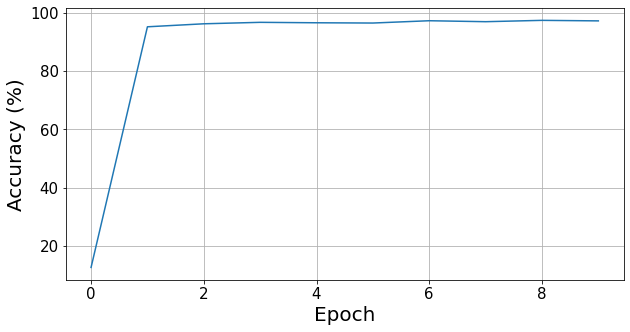

In [ ]:
fs = 20
VI_acc_fig = plt.figure(figsize=(10,5))
plt.plot(VIAcc)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Accuracy (%)',fontsize=fs)
plt.tick_params(labelsize=15)
plt.show()

In [ ]:
VI_acc_fig.savefig("VI_acc_fig.png")

**Training Loss on Trainset**

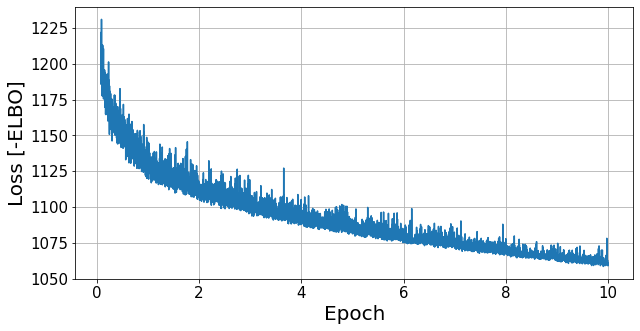

In [ ]:
fs = 20
VI_loss_fig = plt.figure(figsize=(10,5))
x = np.arange(len(VILoss))[50:] / 600.
plt.plot(x, VILoss[50:])
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Loss [-ELBO]',fontsize=fs)
plt.tick_params(labelsize=15)
plt.show()

In [ ]:
VI_loss_fig.savefig("VI_loss_fig.png")

**Training Loss Components**

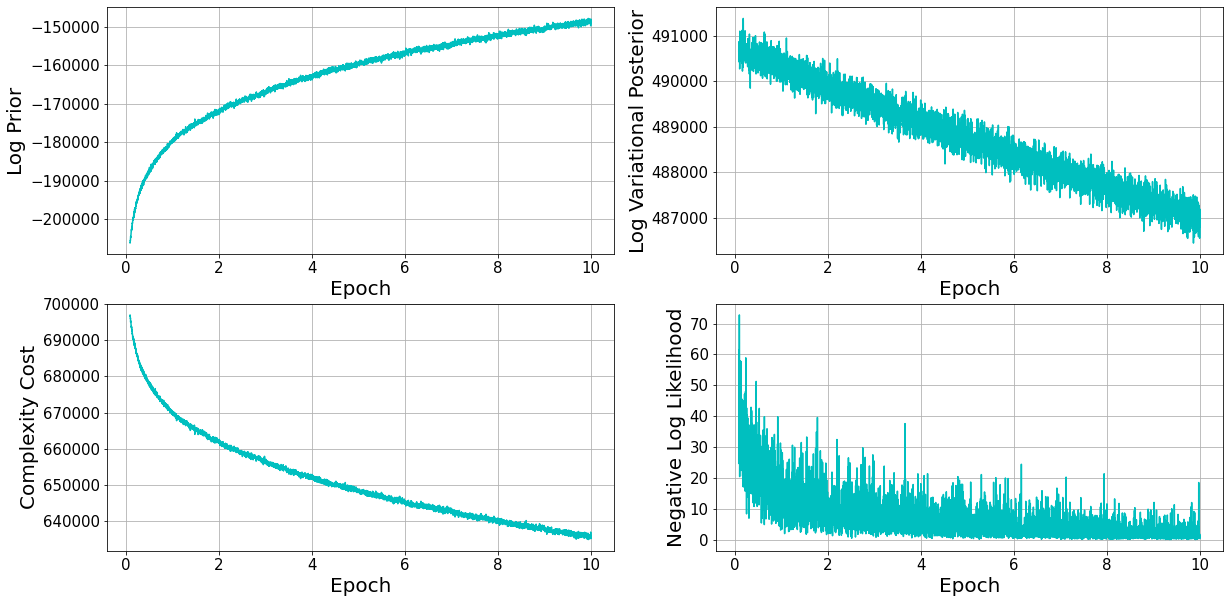

In [ ]:
Components = {'Log Prior':VILog_Prior, 'Log Variational Posterior': VILog_Variational_Posterior, 'Complexity Cost': VIComplexity_Cost, 'Negative Log Likelihood': VINegative_Log_Likelihood}

VI_acc_comp = plt.figure(figsize=(20,10))

for i in np.arange(len(Components)): 

    ax = plt.subplot(2, 2, i + 1)

    key = list(Components.keys())[i]

    fs = 20
    x = np.arange(len(Components[key]))[50:] / 600.
    ax.plot(x, Components[key][50:], color = 'c')
    ax.grid()
    # plt.xlim(0,3000)
    ax.set_xlabel('Epoch',fontsize=fs)
    ax.set_ylabel('{}'.format(key),fontsize=fs)
    ax.tick_params(labelsize=15)

plt.show()

In [ ]:
VI_acc_comp.savefig("VI_acc_comp.png")

**Calculate Training Time**

In [ ]:
VI_training_start = time.time()

%time VImodel = VItraining(train_loader = train_loader, test_loader = test_loader, nepochs = 10, track = False)

VI_training_end = time.time()

VI_training_time = VI_training_end - VI_training_start

print(VI_training_time)

 	Epoch 1/10: Train step 600/600 loss = 1134.1187
 	Epoch 2/10: Train step 600/600 loss = 1111.1091
 	Epoch 3/10: Train step 600/600 loss = 1110.1521
 	Epoch 4/10: Train step 600/600 loss = 1091.8883
 	Epoch 5/10: Train step 600/600 loss = 1086.6639
 	Epoch 6/10: Train step 600/600 loss = 1085.3596
 	Epoch 7/10: Train step 600/600 loss = 1081.6230
 	Epoch 8/10: Train step 600/600 loss = 1070.3097
 	Epoch 9/10: Train step 600/600 loss = 1069.8219
 	Epoch 10/10: Train step 600/600 loss = 1065.7367
CPU times: user 7min 42s, sys: 14.9 s, total: 7min 57s
Wall time: 7min 56s
476.2087163925171


**Accuracy on Testset**

In [ ]:
nruntests = 1000
nbatch = 100
nclass = 10

with torch.no_grad(): 

    VImodel.to(device)
    VImodel.eval()

    correct = 0

    for batch_id, sample in enumerate(test_loader): 

        images, labels = sample
        images, labels = images.to(device), labels.to(device)
        #print(labels.shape)

        pred_list = torch.zeros((nruntests, nbatch, nclass)).to(device)

        for i in np.arange(nruntests): 

            pred = VImodel(images)

            pred_list[i,:,:] = pred
        
        #print(pred_list.shape)

        pred_mean = torch.mean(pred_list, dim = 0)

        #print(pred_mean.shape)

        pred_labels = pred_mean.argmax(dim = 1)

        #print(pred_labels.shape)

        correct += pred_labels.eq(labels).float().sum().item()

    print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
    correct, len(testset), correct/len(testset) * 100.))
    
    VI_acc = correct/len(testset) * 100.



Accuracy on Test Set: 9749.0/10000 (97.4900%)



**In-domain Uncertainty on MNIST (correctly labeled image)**

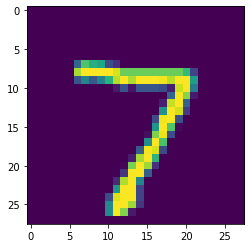

label:  7
predicted label:  7


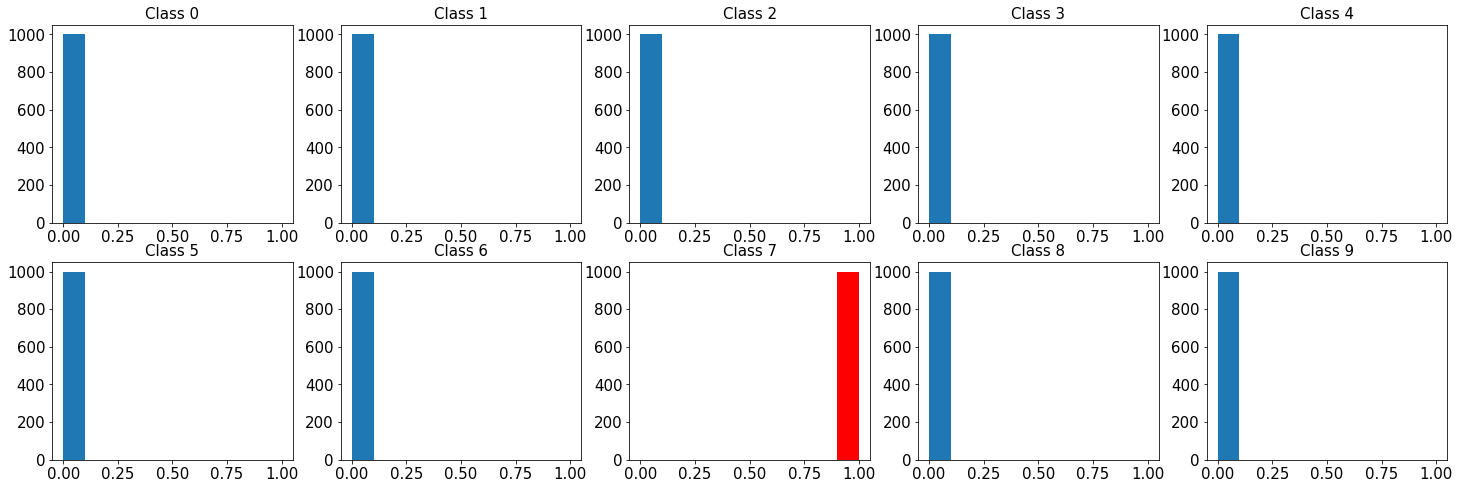

In [ ]:
with torch.no_grad(): 

    data_num = 0

    cor_lab_img = plt.figure()
    plt.imshow(testset.data[data_num].reshape((28,28)))
    plt.show()

    nruntests = 1000
    nclass = 10
    VImodel.to(device)
    VImodel.eval()

    image, label = torch.utils.data.DataLoader(testset[data_num], batch_size=1, shuffle=False)
    image, label = image.to(device), label.to(device)

    pred_list = torch.zeros((nruntests, nclass))

    for i in np.arange(nruntests): 
        
        pred = VImodel(image)

        pred_list[i,:] = pred

    pred_list = torch.exp(pred_list)

    pred_mean = torch.mean(pred_list, dim = 0)

    #print(pred_mean)

    pred_label = pred_mean.argmax(dim = 0)

    pred_label = pred_label.detach().numpy()

    print("label: ", testset.targets[data_num].detach().numpy())
    print("predicted label: ", pred_label if torch.max(pred_mean) > 0.95 else "Prediction Rejected")

    cor_lab_hists = plt.figure(figsize=(25,8))

    for n in np.arange(nclass):

        ax = plt.subplot(2, 5, n + 1)

        prob = []
    
        for i in np.arange(nruntests): 

            prob.append(pred_list[i, n])
        
        if n == pred_label and torch.max(pred_mean) > 0.95:
          
            ax.hist(prob, range = [0,1], bins = 10, color = 'r')

        else: 

            ax.hist(prob, range = [0,1], bins = 10)

        ax.tick_params(labelsize=15)

        ax.set_title("Class {}".format(n), fontsize = 15)

    plt.show()

In [ ]:
cor_lab_img.savefig("cor_lab_img.png")
cor_lab_hists.savefig("cor_lab_hists.png")

**In-domain Uncertainty on MNIST (incorrectly labeled image)**

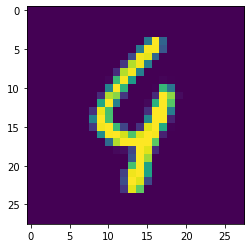

label:  4
predicted label:  Prediction Rejected


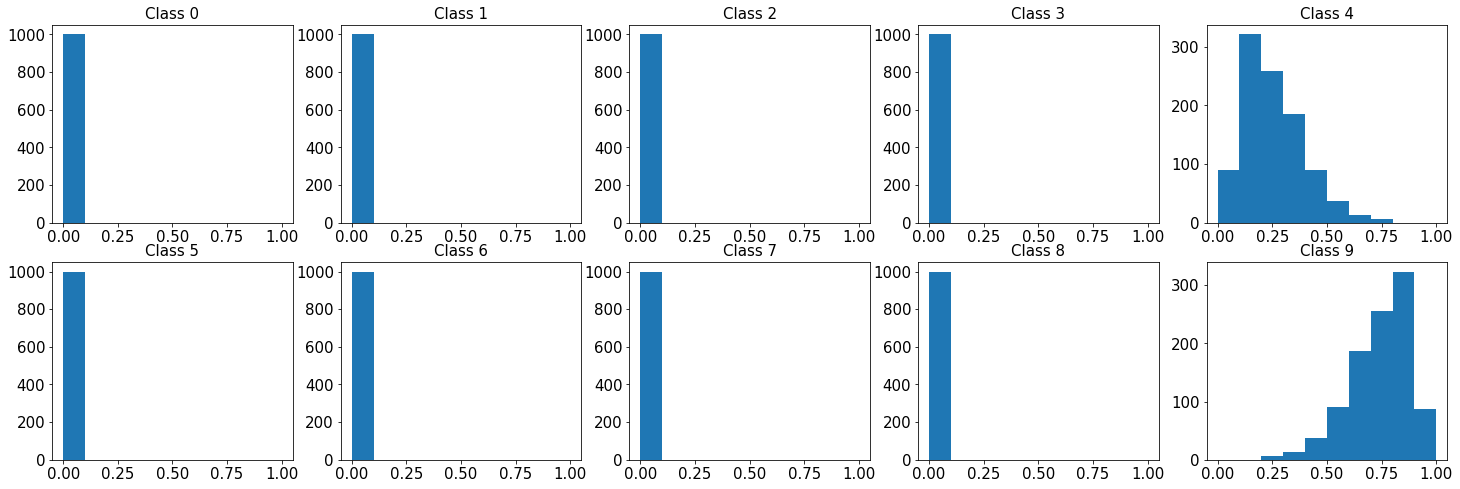

In [ ]:
with torch.no_grad(): 

    data_num = 115

    uncor_lab_img = plt.figure()
    plt.imshow(testset.data[data_num].reshape((28,28)))
    plt.show()

    nruntests = 1000
    nclass = 10
    VImodel.to(device)
    VImodel.eval()

    image, label = torch.utils.data.DataLoader(testset[data_num], batch_size=1, shuffle=False)
    image, label = image.to(device), label.to(device)

    pred_list = torch.zeros((nruntests, nclass))

    for i in np.arange(nruntests): 
        
        pred = VImodel(image)

        pred_list[i,:] = pred

    pred_list = torch.exp(pred_list)

    pred_mean = torch.mean(pred_list, dim = 0)

    #print(pred_mean)

    pred_label = pred_mean.argmax(dim = 0)

    pred_label = pred_label.detach().numpy()

    print("label: ", testset.targets[data_num].detach().numpy())
    print("predicted label: ", pred_label if torch.max(pred_mean) > 0.95 else "Prediction Rejected")

    uncor_lab_hists = plt.figure(figsize=(25,8))

    for n in np.arange(nclass):

        ax = plt.subplot(2, 5, n + 1)

        prob = []
    
        for i in np.arange(nruntests): 

            prob.append(pred_list[i, n])
        
        if n == pred_label and torch.max(pred_mean) > 0.95:
          
            ax.hist(prob, range = [0,1], bins = 10, color = 'r')

        else: 
          
            ax.hist(prob, range = [0,1], bins = 10)

        ax.tick_params(labelsize=15)

        ax.set_title("Class {}".format(n), fontsize = 15)

    plt.show()

In [ ]:
uncor_lab_img.savefig("uncor_lab_img.png") 
uncor_lab_hists.savefig("uncor_lab_hists.png")

**Out-of-domain Uncertainty on Fashion-MNIST**

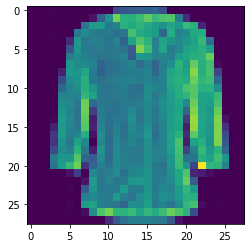

label:  6
predicted label:  Prediction Rejected


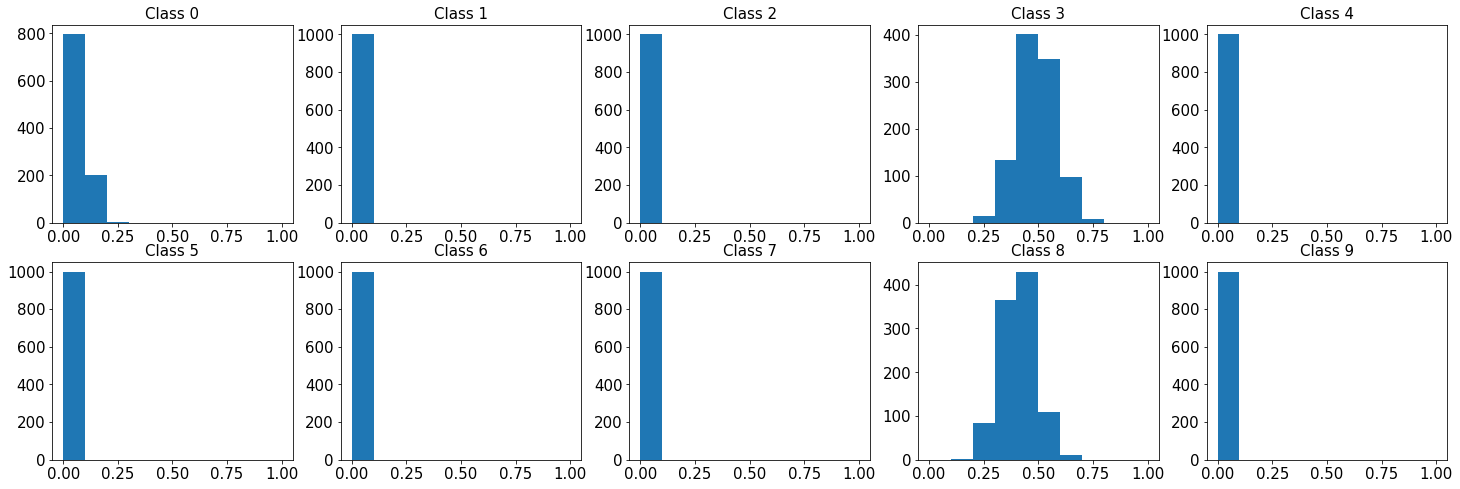

In [ ]:
with torch.no_grad(): 

    data_num = 4

    fashion_img = plt.figure()
    plt.imshow(fmnist_testset.data[data_num].reshape((28,28)))
    plt.show()

    nruntests = 1000
    nclass = 10
    VImodel.to(device)
    VImodel.eval()

    image, label = torch.utils.data.DataLoader(fmnist_testset[data_num], batch_size=1, shuffle=False)
    image, label = image.to(device), label.to(device)

    pred_list = torch.zeros((nruntests, nclass))

    for i in np.arange(nruntests): 
        
        pred = VImodel(image)

        pred_list[i,:] = pred

    pred_list = torch.exp(pred_list)

    pred_mean = torch.mean(pred_list, dim = 0)

    #print(pred_mean)

    pred_label = pred_mean.argmax(dim = 0)

    pred_label = pred_label.detach().numpy()

    print("label: ", fmnist_testset.targets[data_num].detach().numpy())
    print("predicted label: ", pred_label if torch.max(pred_mean) > 0.95 else "Prediction Rejected")

    fashion_hists = plt.figure(figsize=(25,8))

    for n in np.arange(nclass):

        ax = plt.subplot(2, 5, n + 1)

        prob = []
    
        for i in np.arange(nruntests): 

            prob.append(pred_list[i, n])
        
        if n == pred_label and torch.max(pred_mean) > 0.95:
          
            ax.hist(prob, range = [0,1], bins = 10, color = 'r')

        else: 
          
            ax.hist(prob, range = [0,1], bins = 10)

        ax.tick_params(labelsize=15)

        ax.set_title("Class {}".format(n), fontsize = 15)

    plt.show()

In [ ]:
fashion_img.savefig("fashion_img.png") 
fashion_hists.savefig("fashion_hists.png")

**Out-of-domain Uncertainty on White Noise**

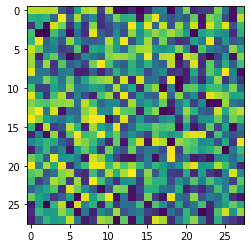

label:  None
predicted label:  Prediction Rejected


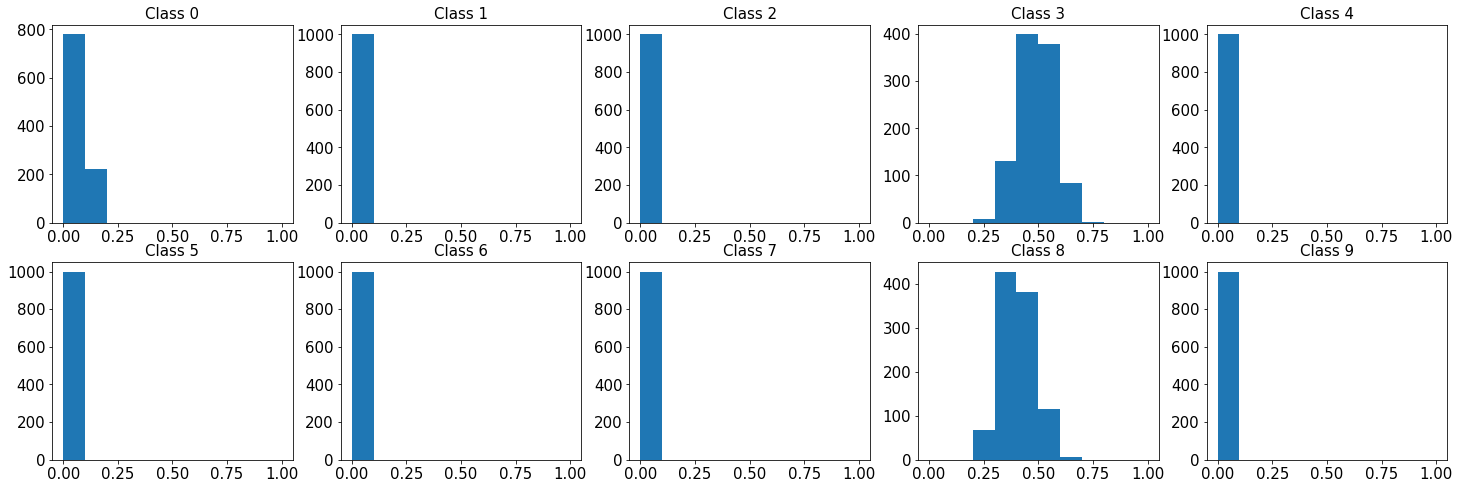

In [ ]:
with torch.no_grad(): 

    white_noise_image = torch.rand((28, 28)) * 255
    white_noise_label = torch.randint(10, ())
    WN = (white_noise_image, white_noise_label)

    WN_img = plt.figure()
    plt.imshow(white_noise_image)
    plt.show()

    nruntests = 1000
    nclass = 10
    VImodel.to(device)
    VImodel.eval()

    WN_image, WN_label = torch.utils.data.DataLoader(WN, batch_size=1, shuffle=False)
    WN_image, WN_label = WN_image.to(device), WN_label.to(device)

    pred_list = torch.zeros((nruntests, nclass))

    for i in np.arange(nruntests): 
        
        pred = VImodel(image)

        pred_list[i,:] = pred

    pred_list = torch.exp(pred_list)

    pred_mean = torch.mean(pred_list, dim = 0)

    #print(pred_mean)

    pred_label = pred_mean.argmax(dim = 0)

    pred_label = pred_label.detach().numpy()

    print("label: ", "None")
    print("predicted label: ", pred_label if torch.max(pred_mean) > 0.95 else "Prediction Rejected")


    WN_hists = plt.figure(figsize=(25,8))

    for n in np.arange(nclass):

        ax = plt.subplot(2, 5, n + 1)

        prob = []
    
        for i in np.arange(nruntests): 

            prob.append(pred_list[i, n])
        
        if n == pred_label and torch.max(pred_mean) > 0.95:
          
            ax.hist(prob, range = [0,1], bins = 10, color = 'r')

        else: 
          
            ax.hist(prob, range = [0,1], bins = 10)

        ax.tick_params(labelsize=15)

        ax.set_title("Class {}".format(n), fontsize = 15)

    plt.show()

In [ ]:
WN_img.savefig("WN_img.png") 
WN_hists.savefig("WN_hists.png")

**-------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Point Estimate MLP**

**MLP**

In [ ]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.w1 = nn.Parameter(torch.randn(200, 784))
        self.b1 = nn.Parameter(torch.randn(200))
        self.w2 = nn.Parameter(torch.randn(10, 200))
        self.b2 = nn.Parameter(torch.randn(10))

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = x @ self.w1.t() + self.b1
        x = F.relu(x)
        x = x @ self.w2.t() + self.b2
        return x

**Define Point Estimate Training Process**

In [ ]:
def point_estimate_training(train_loader, test_loader, nepochs, nbatch = 100, track = True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')): 
    
    model = MLP().to(device)
    model.train()
            
    optimizer = torch.optim.SGD(model.parameters(), lr = 4e-3)
    optimizer.zero_grad()
            
    if track: 
        Loss = []
        Acc = []

    criteon = nn.CrossEntropyLoss().to(device)

    batchLen = len(train_loader)
    ntest = len(test_loader) * nbatch
    digitsBatchLen = len(str(batchLen))

    for n in np.arange(nepochs):

        if track: 

            correct = 0
            for batch_id, sample in enumerate(test_loader) :

                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                
                pred = model(images)
                pred = pred.argmax(dim = 1)
                correct += pred.eq(labels).float().sum().item()
            print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
                correct, ntest, correct/ntest * 100.))
            print("--------------------------------------------------------")
            
            Acc.append(correct/ntest * 100.)
        
        for batch_id, sample in enumerate(train_loader):
                    
            images, labels = sample
            images, labels = images.to(device), labels.to(device)
                    
            logits = model(images)
            loss = criteon(logits, labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            if track: 

                Loss.append(loss.detach().cpu().item())
                    
            print("\r", ("\tEpoch {}/{}: Train step {"+(":0{}d".format(digitsBatchLen))+"}/{} loss = {:.4f}").format(
                                                      n+1, nepochs,
                                                      batch_id+1,
                                                      batchLen, 
                                                      loss.detach().cpu().item()), 
                        end="")
        print("")

    if track: 

        return model, Loss, Acc

    else:

        return model

**Training by Point Estimate**

In [ ]:
PEmodel, PELoss, PEAcc = point_estimate_training(train_loader = train_loader, test_loader = test_loader, nepochs = 10, track = True)


Accuracy on Test Set: 621.0/10000 (6.2100%)

--------------------------------------------------------
 	Epoch 1/10: Train step 600/600 loss = 42.3969

Accuracy on Test Set: 8061.0/10000 (80.6100%)

--------------------------------------------------------
 	Epoch 2/10: Train step 600/600 loss = 26.6668

Accuracy on Test Set: 8518.0/10000 (85.1800%)

--------------------------------------------------------
 	Epoch 3/10: Train step 600/600 loss = 8.3641

Accuracy on Test Set: 8675.0/10000 (86.7500%)

--------------------------------------------------------
 	Epoch 4/10: Train step 600/600 loss = 4.9223

Accuracy on Test Set: 8803.0/10000 (88.0300%)

--------------------------------------------------------
 	Epoch 5/10: Train step 600/600 loss = 9.7799

Accuracy on Test Set: 8886.0/10000 (88.8600%)

--------------------------------------------------------
 	Epoch 6/10: Train step 600/600 loss = 10.1803

Accuracy on Test Set: 8936.0/10000 (89.3600%)

---------------------------------------

**Training Accuracy on Testset**

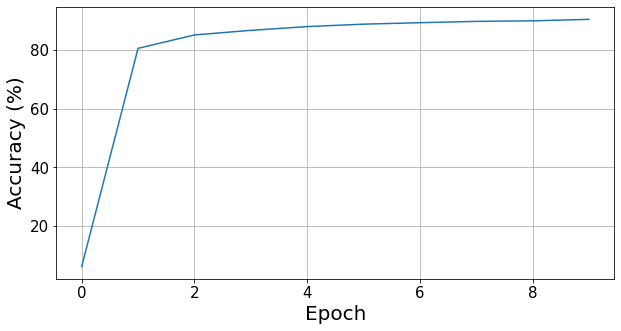

In [ ]:
fs = 20
PE_acc_fig = plt.figure(figsize=(10,5))
plt.plot(PEAcc)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Accuracy (%)',fontsize=fs)
plt.tick_params(labelsize=15)
plt.show()

In [ ]:
PE_acc_fig.savefig("PE_acc_fig.png")

**Training Loss on Trainset**

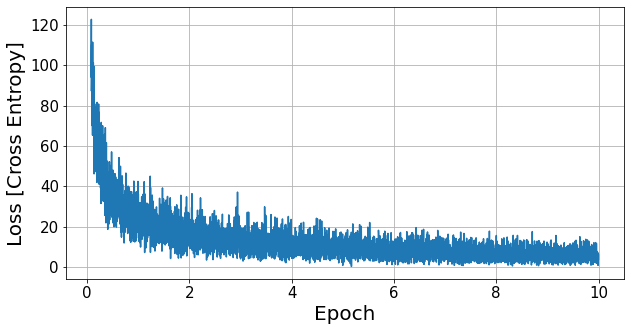

In [ ]:
fs = 20
PE_loss_fig = plt.figure(figsize=(10,5))
x = np.arange(len(PELoss))[50:] / 600.
plt.plot(x, PELoss[50:])
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Loss [Cross Entropy]',fontsize=fs)
plt.tick_params(labelsize=15)
plt.show()

In [ ]:
PE_loss_fig.savefig("PE_loss_fig.png")

**Calculate Training Time**

In [ ]:
Point_Estimate_training_start = time.time()

%time PEmodel = point_estimate_training(train_loader = train_loader, test_loader = test_loader, nepochs = 10, track = False)

Point_Estimate_training_end = time.time()

Point_Estimate_training_time = Point_Estimate_training_end - Point_Estimate_training_start

print(Point_Estimate_training_time)

 	Epoch 1/10: Train step 600/600 loss = 16.5617
 	Epoch 2/10: Train step 600/600 loss = 21.5871
 	Epoch 3/10: Train step 600/600 loss = 7.2224
 	Epoch 4/10: Train step 600/600 loss = 14.3904
 	Epoch 5/10: Train step 600/600 loss = 7.6237
 	Epoch 6/10: Train step 600/600 loss = 8.1837
 	Epoch 7/10: Train step 600/600 loss = 8.1936
 	Epoch 8/10: Train step 600/600 loss = 2.5701
 	Epoch 9/10: Train step 600/600 loss = 6.9290
 	Epoch 10/10: Train step 600/600 loss = 5.5220
CPU times: user 2min 40s, sys: 2.76 s, total: 2min 43s
Wall time: 2min 42s
162.05998420715332


**Accuracy on Testset**

In [ ]:
with torch.no_grad(): 

    PEmodel.to(device)
    PEmodel.eval()

    correct = 0

    for batch_id, sample in enumerate(test_loader): 

        images, labels = sample
        images, labels = images.to(device), labels.to(device)

        pred = PEmodel(images)

        pred_labels = pred.argmax(dim = 1)

        correct += pred_labels.eq(labels).float().sum().item()

    print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
    correct, len(testset), correct/len(testset) * 100.))
    
    Point_Estimate_acc = correct/len(testset) * 100.



Accuracy on Test Set: 9064.0/10000 (90.6400%)



**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Point Estimate + Ensembles**

**MLP**

In [ ]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.w1 = nn.Parameter(torch.randn(200, 784))
        self.b1 = nn.Parameter(torch.randn(200))
        self.w2 = nn.Parameter(torch.randn(10, 200))
        self.b2 = nn.Parameter(torch.randn(10))

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = x @ self.w1.t() + self.b1
        x = F.relu(x)
        x = x @ self.w2.t() + self.b2
        return x

**Define Training Process**

In [ ]:
def ensemble_training(train_loader, test_loader, nepochs, nmodels, nbatch = 100, track = True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')): 
    
    Models = {}

    if track: 

        Loss = {}
        Acc = {}

    batchLen = len(train_loader)
    ntest = len(test_loader) * nbatch
    digitsBatchLen = len(str(batchLen))

    for i in np.arange(nmodels): 
        print("Training model {}/{}:".format(i+1, nmodels))

        model = MLP().to(device)
        model.train()
                
        optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)
        optimizer.zero_grad()

        criteon = nn.CrossEntropyLoss().to(device)

        if track: 
            Loss[i] = []
            Acc[i] = []

        for n in np.arange(nepochs):

            if track: 

                correct = 0
                for batch_id, sample in enumerate(test_loader) :

                    images, labels = sample
                    images, labels = images.to(device), labels.to(device)
                    
                    pred = model(images)
                    pred = pred.argmax(dim = 1)
                    correct += pred.eq(labels).float().sum().item()
                print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
                    correct, ntest, correct/ntest * 100.))
                print("--------------------------------------------------------")
                
                Acc[i].append(correct/ntest * 100.)
            
            for batch_id, sample in enumerate(train_loader):
                        
                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                        
                logits = model(images)
                loss = criteon(logits, labels)

                optimizer.zero_grad()
                loss.backward()

                optimizer.step()

                if track: 

                    Loss[i].append(loss.detach().cpu().item())
                        
                print("\r", ("\tEpoch {}/{}: Train step {"+(":0{}d".format(digitsBatchLen))+"}/{} loss = {:.4f}").format(
                                                          n+1, nepochs,
                                                          batch_id+1,
                                                          batchLen, 
                                                          loss.detach().cpu().item()), 
                            end="")
            print("")

        Models[i] = model

        print("========================================================")

    if track: 

        return Models, Loss, Acc

    else:

        return Models


**Training by Deep Ensemble**

In [ ]:
Ens_Models, Ens_Loss, Ens_Acc = ensemble_training(train_loader = train_loader, test_loader = test_loader, nepochs = 10, nmodels = 10, nbatch = 100, track = True)

Training model 1/10:

Accuracy on Test Set: 1605.0/10000 (16.0500%)

--------------------------------------------------------
 	Epoch 1/10: Train step 600/600 loss = 16.2272

Accuracy on Test Set: 8696.0/10000 (86.9600%)

--------------------------------------------------------
 	Epoch 2/10: Train step 600/600 loss = 7.0086

Accuracy on Test Set: 8921.0/10000 (89.2100%)

--------------------------------------------------------
 	Epoch 3/10: Train step 600/600 loss = 6.6517

Accuracy on Test Set: 9019.0/10000 (90.1900%)

--------------------------------------------------------
 	Epoch 4/10: Train step 600/600 loss = 8.1607

Accuracy on Test Set: 9073.0/10000 (90.7300%)

--------------------------------------------------------
 	Epoch 5/10: Train step 600/600 loss = 2.4487

Accuracy on Test Set: 9106.0/10000 (91.0600%)

--------------------------------------------------------
 	Epoch 6/10: Train step 600/600 loss = 9.0399

Accuracy on Test Set: 9173.0/10000 (91.7300%)

------------------

**Training Accuracy on Testset**

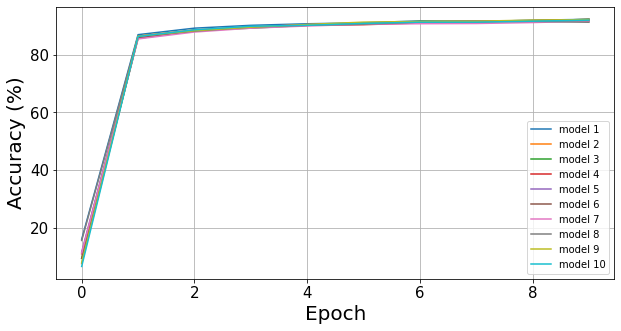

In [ ]:
fs = 20
Ens_acc_fig = plt.figure(figsize=(10,5))
for i in range(len(Ens_Acc)): 
  plt.plot(Ens_Acc[i], label = "model {}".format(i+1))
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Accuracy (%)',fontsize=fs)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

In [ ]:
Ens_acc_fig.savefig("Ens_acc_fig.png")

**Training Loss on Trainset**

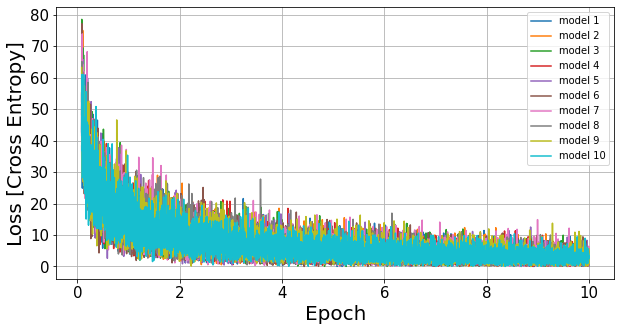

In [ ]:
fs = 20
Ens_loss_fig = plt.figure(figsize=(10,5))
for i in range(len(Ens_Loss)): 
    x = np.arange(len(Ens_Loss[i]))[50:] / 600.
    plt.plot(x, Ens_Loss[i][50:], label = "model {}".format(i+1))
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Loss [Cross Entropy]',fontsize=fs)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

In [ ]:
Ens_loss_fig.savefig("Ens_loss_fig.png")

**Calculate Training Time**

In [ ]:
Ens_training_start = time.time()

%time Ens_Models = ensemble_training(train_loader = train_loader, test_loader = test_loader, nepochs = 10, nmodels = 10, nbatch = 100, track = False)

Ens_training_end = time.time()

Ens_training_time = Ens_training_end - Ens_training_start

print(Ens_training_time)

Training model 1/10:
 	Epoch 1/10: Train step 600/600 loss = 10.2228
 	Epoch 2/10: Train step 600/600 loss = 5.0498
 	Epoch 3/10: Train step 600/600 loss = 4.3331
 	Epoch 4/10: Train step 600/600 loss = 8.0033
 	Epoch 5/10: Train step 600/600 loss = 2.1560
 	Epoch 6/10: Train step 600/600 loss = 4.4103
 	Epoch 7/10: Train step 600/600 loss = 5.9416
 	Epoch 8/10: Train step 600/600 loss = 2.6785
 	Epoch 9/10: Train step 600/600 loss = 5.6515
 	Epoch 10/10: Train step 600/600 loss = 6.2010
Training model 2/10:
 	Epoch 1/10: Train step 600/600 loss = 10.0663
 	Epoch 2/10: Train step 600/600 loss = 9.1348
 	Epoch 3/10: Train step 600/600 loss = 4.9742
 	Epoch 4/10: Train step 600/600 loss = 4.4233
 	Epoch 5/10: Train step 600/600 loss = 2.1723
 	Epoch 6/10: Train step 600/600 loss = 1.0647
 	Epoch 7/10: Train step 600/600 loss = 2.2251
 	Epoch 8/10: Train step 600/600 loss = 2.7175
 	Epoch 9/10: Train step 600/600 loss = 2.9447
 	Epoch 10/10: Train step 600/600 loss = 3.4058
Training model

**Accuracy on Testset**

In [ ]:
nruntests = 1000
nbatch = 100
nclass = 10
nmodels = 10

with torch.no_grad(): 

    correct = 0

    for batch_id, sample in enumerate(test_loader): 

        images, labels = sample
        images, labels = images.to(device), labels.to(device)
        #print(labels.shape)

        pred_list = torch.zeros((nruntests, nbatch, nclass)).to(device)

        for i in np.arange(nruntests): 

            model_num = np.random.randint(nmodels)
            model = Ens_Models[model_num]

            model.to(device)
            model.eval()

            pred = model(images)

            pred_list[i,:,:] = pred
        
        #print(pred_list.shape)

        pred_mean = torch.mean(pred_list, dim = 0)

        #print(pred_mean.shape)

        pred_labels = pred_mean.argmax(dim = 1)

        #print(pred_labels.shape)

        correct += pred_labels.eq(labels).float().sum().item()

    print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
    correct, len(testset), correct/len(testset) * 100.))
    
    Ens_acc = correct/len(testset) * 100.



Accuracy on Test Set: 9670.0/10000 (96.7000%)



**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Variational Inference + Ensemble**

**Define Variational Inference Training Process**

In [ ]:
def ensemble_VItraining(train_loader, test_loader, nepochs, nmodels, nbatch = 100, track = True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')): 
    
    Models = {}

    if track: 

        Loss = {}
        Acc = {}

    batchLen = len(train_loader)
    ntest = len(test_loader) * nbatch
    digitsBatchLen = len(str(batchLen))

    for i in np.arange(nmodels): 
        print("Training model {}/{}:".format(i+1, nmodels))

        model = BayesianMLP().to(device)
        model.train()
                
        optimizer = torch.optim.SGD(model.parameters(), lr = 6e-3)
        optimizer.zero_grad()

        if track: 
            Loss[i] = []
            Acc[i] = []

        for n in np.arange(nepochs):

            if track: 

                correct = 0
                for batch_id, sample in enumerate(test_loader) :

                    images, labels = sample
                    images, labels = images.to(device), labels.to(device)
                    
                    pred = model(images)
                    pred = pred.argmax(dim = 1)
                    correct += pred.eq(labels).float().sum().item()
                print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
                    correct, ntest, correct/ntest * 100.))
                print("--------------------------------------------------------")
                
                Acc[i].append(correct/ntest * 100.)
            
            for batch_id, sample in enumerate(train_loader):
                        
                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                        
                loss, log_prior, log_variational_posterior, negative_log_likelihood = model.sample_elbo(images, labels, BATCH_SIZE = nbatch, NUM_BATCHES = batchLen)

                optimizer.zero_grad()
                loss.backward()

                optimizer.step()

                if track: 

                    Loss[i].append(loss.detach().cpu().item())
                        
                print("\r", ("\tEpoch {}/{}: Train step {"+(":0{}d".format(digitsBatchLen))+"}/{} loss = {:.4f}").format(
                                                          n+1, nepochs,
                                                          batch_id+1,
                                                          batchLen, 
                                                          loss.detach().cpu().item()), 
                            end="")
            print("")

        Models[i] = model

        print("========================================================")

    if track: 

        return Models, Loss, Acc

    else:

        return Models

**Training by Variational Inference + Ensemble**

In [ ]:
Ens_VIModels, Ens_VILoss, Ens_VIAcc = ensemble_VItraining(train_loader, test_loader, nepochs = 10, nmodels = 10, nbatch = 100, track = True)

Training model 1/10:

Accuracy on Test Set: 571.0/10000 (5.7100%)

--------------------------------------------------------
 	Epoch 1/10: Train step 600/600 loss = 1143.8290

Accuracy on Test Set: 9494.0/10000 (94.9400%)

--------------------------------------------------------
 	Epoch 2/10: Train step 600/600 loss = 1125.1239

Accuracy on Test Set: 9489.0/10000 (94.8900%)

--------------------------------------------------------
 	Epoch 3/10: Train step 600/600 loss = 1120.1180

Accuracy on Test Set: 9618.0/10000 (96.1800%)

--------------------------------------------------------
 	Epoch 4/10: Train step 600/600 loss = 1108.1871

Accuracy on Test Set: 9691.0/10000 (96.9100%)

--------------------------------------------------------
 	Epoch 5/10: Train step 600/600 loss = 1112.0929

Accuracy on Test Set: 9686.0/10000 (96.8600%)

--------------------------------------------------------
 	Epoch 6/10: Train step 600/600 loss = 1088.1503

Accuracy on Test Set: 9656.0/10000 (96.5600%)

---

**Training Accuracy on Testset**

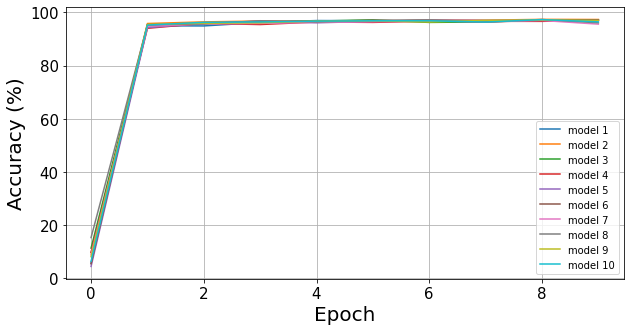

In [ ]:
fs = 20
Ens_VIacc_fig = plt.figure(figsize=(10,5))
for i in range(len(Ens_VIAcc)): 
  plt.plot(Ens_VIAcc[i], label = "model {}".format(i+1))
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Accuracy (%)',fontsize=fs)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

In [ ]:
Ens_VIacc_fig.savefig("Ens_VIacc_fig.png")

**Training Loss on Trainset**

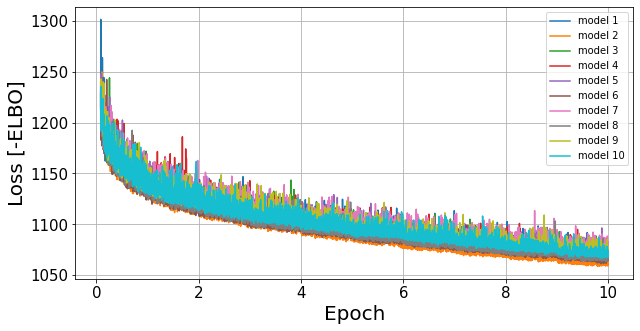

In [ ]:
fs = 20
Ens_VIloss_fig = plt.figure(figsize=(10,5))
for i in range(len(Ens_VILoss)): 
    x = np.arange(len(Ens_VILoss[i]))[50:] / 600.
    plt.plot(x, Ens_VILoss[i][50:], label = "model {}".format(i+1))
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Loss [-ELBO]',fontsize=fs)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

In [ ]:
Ens_VIloss_fig.savefig("Ens_VIloss_fig.png")

**Calculate Training Time**

In [ ]:
Ens_VItraining_start = time.time()

%time Ens_VIModels = ensemble_VItraining(train_loader, test_loader, nepochs = 10, nmodels = 10, nbatch = 100, track = False)

Ens_VItraining_end = time.time()

Ens_VItraining_time = Ens_VItraining_end - Ens_VItraining_start

print(Ens_VItraining_time)

Training model 1/10:
 	Epoch 1/10: Train step 600/600 loss = 1149.5453
 	Epoch 2/10: Train step 600/600 loss = 1115.6996
 	Epoch 3/10: Train step 600/600 loss = 1106.3076
 	Epoch 4/10: Train step 600/600 loss = 1104.8948
 	Epoch 5/10: Train step 600/600 loss = 1097.5658
 	Epoch 6/10: Train step 600/600 loss = 1087.2404
 	Epoch 7/10: Train step 600/600 loss = 1080.1653
 	Epoch 8/10: Train step 600/600 loss = 1080.6036
 	Epoch 9/10: Train step 600/600 loss = 1068.3672
 	Epoch 10/10: Train step 600/600 loss = 1070.5305
Training model 2/10:
 	Epoch 1/10: Train step 600/600 loss = 1138.9711
 	Epoch 2/10: Train step 600/600 loss = 1133.8229
 	Epoch 3/10: Train step 600/600 loss = 1106.4509
 	Epoch 4/10: Train step 600/600 loss = 1100.8108
 	Epoch 5/10: Train step 600/600 loss = 1090.2715
 	Epoch 6/10: Train step 600/600 loss = 1087.3562
 	Epoch 7/10: Train step 600/600 loss = 1083.2522
 	Epoch 8/10: Train step 600/600 loss = 1079.0367
 	Epoch 9/10: Train step 600/600 loss = 1071.1637
 	Epoch

**Accuracy on Testset**

In [ ]:
nruntests = 1000
nbatch = 100
nclass = 10
nmodels = 10

with torch.no_grad(): 

    correct = 0

    for batch_id, sample in enumerate(test_loader): 

        images, labels = sample
        images, labels = images.to(device), labels.to(device)
        #print(labels.shape)

        pred_list = torch.zeros((nruntests, nbatch, nclass)).to(device)

        for i in np.arange(nruntests): 

            model_num = np.random.randint(nmodels)
            model = Ens_VIModels[model_num]

            model.to(device)
            model.eval()

            pred = model(images)

            pred_list[i,:,:] = pred
        
        #print(pred_list.shape)

        pred_mean = torch.mean(pred_list, dim = 0)

        #print(pred_mean.shape)

        pred_labels = pred_mean.argmax(dim = 1)

        #print(pred_labels.shape)

        correct += pred_labels.eq(labels).float().sum().item()

    print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
    correct, len(testset), correct/len(testset) * 100.))
    
    Ens_VIacc = correct/len(testset) * 100.


Accuracy on Test Set: 9851.0/10000 (98.5100%)



In [ ]:
nruntests = 1000
nbatch = 100
nclass = 10
nmodels = 10

with torch.no_grad(): 

    correct = 0

    for batch_id, sample in enumerate(test_loader): 

        images, labels = sample
        images, labels = images.to(device), labels.to(device)
        #print(labels.shape)

        pred_list = torch.zeros((nruntests, nbatch, nclass)).to(device)

        for i in np.arange(nruntests): 

            model_num = np.random.randint(nmodels)
            model = Ens_VIModels[model_num]

            model.to(device)
            model.eval()

            pred = model(images)

            pred_list[i,:,:] = pred
        
        #print(pred_list.shape)

        pred_mean = torch.mean(pred_list, dim = 0)

        #print(pred_mean.shape)

        pred_labels = pred_mean.argmax(dim = 1)

        #print(pred_labels.shape)

        correct += pred_labels.eq(labels).float().sum().item()

    print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
    correct, len(testset), correct/len(testset) * 100.))
    
    Ens_VIacc = correct/len(testset) * 100.



Accuracy on Test Set: 9838.0/10000 (98.3800%)



**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Hamiltonian Monte Carlo (HMC)**

In [ ]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
HMC_model = MLP()

In [ ]:
N_tr = 60000
N_test = 10000


x_train = trainset.train_data[:N_tr].float()/255.
print(x_train.shape)
x_train = x_train.view(-1, 784)
print(x_train.shape)
y_train = trainset.train_labels[:N_tr].reshape((-1,1)).float()
print(y_train.shape)
x_test = testset.train_data[:N_test].float()/255.
print(x_test.shape)
x_test = x_test.view(-1, 784)
print(x_test.shape)
y_test = testset.train_labels[:N_test].reshape((-1,1)).float()
print(y_test.shape)

x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])
torch.Size([60000, 784])
torch.Size([60000, 1])
torch.Size([10000, 28, 28])
torch.Size([10000, 784])
torch.Size([10000, 1])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
tau_list = []
tau = 10.#./100. # 1/50
for w in HMC_model.parameters():
#     print(w.nelement())
#     tau_list.append(tau/w.nelement())
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

hamiltorch.set_random_seed(123)
HMC_model = MLP()
params_init = hamiltorch.util.flatten(HMC_model).to(device).clone()
print(params_init.shape)

step_size = 0.001
num_samples = 1000
L = 20
tau_out = 1.
normalizing_const = 1.
burn =0 #GPU: 3000

torch.Size([159010])


In [ ]:
HMC_training_start = time.time()

%time params_hmc = hamiltorch.sample_model(HMC_model, x_train, y_train, params_init=params_init, model_loss='multi_class_linear_output', num_samples=num_samples, burn = burn, step_size=step_size, num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list, normalizing_const=normalizing_const)

HMC_training_end = time.time()

HMC_training_time = HMC_training_end - HMC_training_start

print(HMC_training_time)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec

Acceptance Rate 0.96
CPU times: user 4h 48min 11s, sys: 1min 5s, total: 4h 49min 16s
Wall time: 4h 48min 26s
17306.12430167198


In [ ]:
pred_list, log_prob_list = hamiltorch.predict_model(HMC_model, x = x_test, y = y_test, samples=params_hmc, model_loss='multi_class_log_softmax_output', tau_out=1., tau_list=tau_list)
print(pred_list.shape)

_, pred = torch.max(pred_list, 2)
print(pred.shape)
acc = []
acc = torch.zeros( int(len(params_hmc))-1)
nll = torch.zeros( int(len(params_hmc))-1)
ensemble_proba = F.softmax(pred_list[0], dim=-1)
for s in range(1,len(params_hmc)):
    _, pred = torch.max(pred_list[:s].mean(0), -1)
    acc[s-1] = (pred.float() == y_test.flatten()).sum().float()/y_test.shape[0]
    ensemble_proba += F.softmax(pred_list[s], dim=-1)
    nll[s-1] = F.nll_loss(torch.log(ensemble_proba.cpu()/(s+1)), y_test[:].long().cpu().flatten(), reduction='mean')

torch.Size([1000, 10000, 10])
torch.Size([1000, 10000])


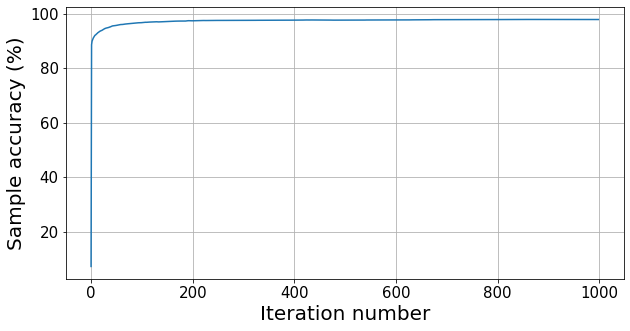

Accuracy: 97.8400%


In [ ]:
fs = 20
HMC_acc_fig = plt.figure(figsize=(10,5))
plt.plot(acc * 100.)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Sample accuracy (%)',fontsize=fs)
plt.tick_params(labelsize=15)
plt.show()

print("Accuracy: {:.4f}%".format(acc[-1].detach().numpy() * 100.))

HMC_acc = (acc[-1].detach().numpy() * 100.).round(4)

In [ ]:
HMC_acc_fig.savefig("HMC_acc_fig.png")

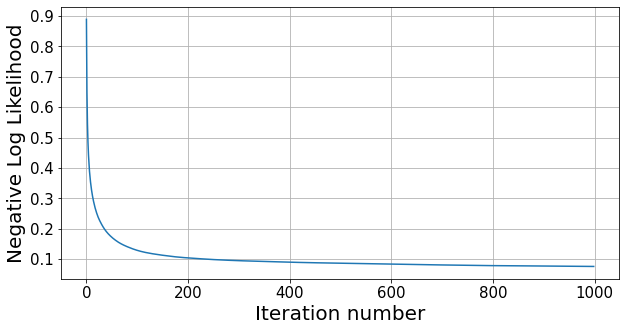

In [ ]:
fs = 20
HMC_loss_fig = plt.figure(figsize=(10,5))
plt.plot(nll)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Negative Log Likelihood',fontsize=fs)
plt.tick_params(labelsize=15)
plt.show()

In [ ]:
HMC_loss_fig.savefig("HMC_loss_fig.png")

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Comparison**

**Training Time Comparison**

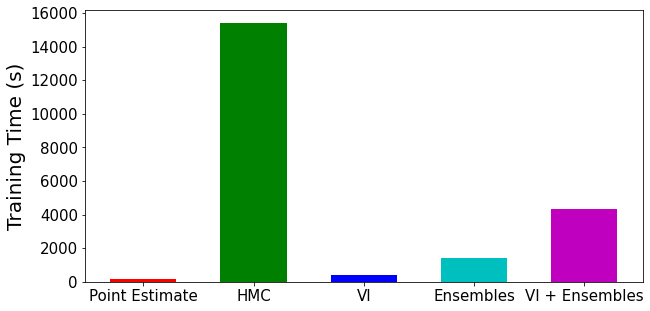

In [ ]:
fs = 20
time_comparison_fig = plt.figure(figsize=(10,5))
training_approach = ['Point Estimate', 'HMC', 'VI', 'Ensembles', 'VI + Ensembles']
training_time = [Point_Estimate_training_time, HMC_training_time, VI_training_time, Ens_training_time, Ens_VItraining_time]
color_back = ['r', 'g', 'b', 'c', 'm']

plt.bar(training_approach, training_time, width=0.6, color=color_back)
plt.ylabel('Training Time (s)',fontsize=fs)
plt.tick_params(labelsize=15)
plt.show()

In [ ]:
time_comparison_fig.savefig("time_comparison_fig.png")

**Accuracy on Testset Comparison**

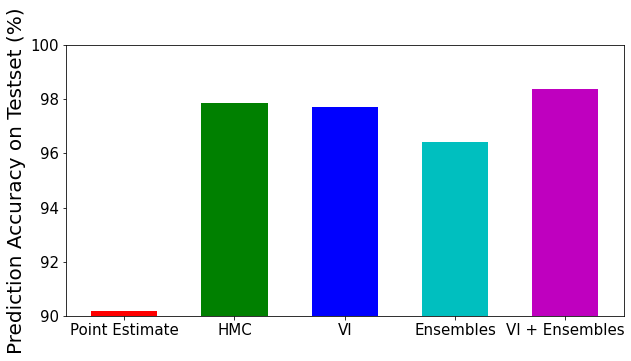

[90.19, 97.84, 97.7, 96.41, 98.38]


In [ ]:
fs = 20
acc_comparison_fig = plt.figure(figsize=(10,5))
training_approach = ['Point Estimate', 'HMC', 'VI', 'Ensembles', 'VI + Ensembles']
acc_testset = [Point_Estimate_acc, HMC_acc, VI_acc, Ens_acc, Ens_VIacc]
color_back = ['r', 'g', 'b', 'c', 'm']

plt.bar(training_approach, acc_testset, width=0.6, color=color_back)
plt.ylim(90,100)
plt.ylabel('Prediction Accuracy on Testset (%)',fontsize=fs)
plt.tick_params(labelsize=15)
plt.show()

print(acc_testset)

In [ ]:
acc_comparison_fig.savefig("acc_comparison_fig.png")

In [ ]:
np.save('./Point_Estimate_acc.npy', Point_Estimate_acc)
np.save('./HMC_acc.npy', HMC_acc)
np.save('./VI_acc.npy', VI_acc)
np.save('./Ens_acc.npy', Ens_acc)
np.save('./Ens_VIacc.npy', Ens_VIacc)

np.save('./Point_Estimate_training_time.npy', Point_Estimate_training_time)
np.save('./HMC_training_time.npy', HMC_training_time)
np.save('./VI_training_time.npy', VI_training_time)
np.save('./Ens_training_time.npy', Ens_training_time)
np.save('./Ens_VItraining_time.npy', Ens_VItraining_time)

In [ ]:
Point_Estimate_acc = np.load('/content/drive/MyDrive/Training Time and Performance Comparison/Point_Estimate_acc.npy', allow_pickle=True).item()
HMC_acc = np.load('/content/drive/MyDrive/Training Time and Performance Comparison/HMC_acc.npy', allow_pickle=True).item()
VI_acc = np.load('/content/drive/MyDrive/Training Time and Performance Comparison/VI_acc.npy', allow_pickle=True).item()
Ens_acc = np.load('/content/drive/MyDrive/Training Time and Performance Comparison/Ens_acc.npy', allow_pickle=True).item()
Ens_VIacc = np.load('/content/drive/MyDrive/Training Time and Performance Comparison/Ens_VIacc.npy', allow_pickle=True).item()

Point_Estimate_training_time = np.load('/content/drive/MyDrive/Training Time and Performance Comparison/Point_Estimate_training_time.npy', allow_pickle=True).item()
HMC_training_time = np.load('/content/drive/MyDrive/Training Time and Performance Comparison/HMC_training_time.npy', allow_pickle=True).item()
VI_training_time = np.load('/content/drive/MyDrive/Training Time and Performance Comparison/VI_training_time.npy', allow_pickle=True).item()
Ens_training_time = np.load('/content/drive/MyDrive/Training Time and Performance Comparison/Ens_training_time.npy', allow_pickle=True).item()
Ens_VItraining_time = np.load('/content/drive/MyDrive/Training Time and Performance Comparison/Ens_VItraining_time.npy', allow_pickle=True).item()

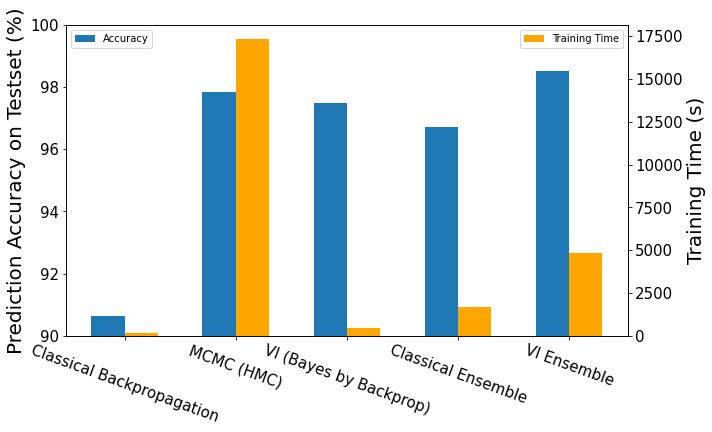

In [ ]:
fs = 20
fig_train_compare, ax1 = plt.subplots(figsize=(10,6))
ax1.set_ylabel('Prediction Accuracy on Testset (%)',fontsize=fs)
ax1.set_ylim(90,100)
Training_Methods = ['Classical Backpropagation', 'MCMC (HMC)', 'VI (Bayes by Backprop)', 'Classical Ensemble', 'VI Ensemble']
acc_testset = [Point_Estimate_acc, HMC_acc, VI_acc, Ens_acc, Ens_VIacc]
ax1.bar(Training_Methods, acc_testset, width=-0.3, align='edge', label = 'Accuracy')
ax1.tick_params(labelsize=15)
ax1.set_xticklabels(Training_Methods, rotation = 340)

ax1.set_xticklabels(ax1.get_xticklabels())

ax2 = ax1.twinx()
ax2.set_ylabel('Training Time (s)',fontsize=fs)
#ax2.set_ylim()
training_time = [Point_Estimate_training_time, HMC_training_time, VI_training_time, Ens_training_time, Ens_VItraining_time]
ax2.bar(Training_Methods, training_time, width=0.3, align='edge', color = 'orange', label = 'Training Time')
ax2.tick_params(labelsize=15)

ax1.legend(loc='upper left')
ax2.legend()
fig_train_compare.tight_layout()
fig_train_compare.show()

In [ ]:
fig_train_compare.savefig("fig_train_compare.png")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
